# **Initialization**

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import seaborn as sns
import glob as glob
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. Load dan Pra-pemrosesan Data
path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Training and Testing Sets" # use your path
files = [file for file in glob.glob(path + "**/*.csv", recursive=True)]

[print(f) for f in files]

data = [pd.read_csv(f) for f in files]

/content/drive/MyDrive/Colab Notebooks/Dataset/Training and Testing Sets/UNSW_NB15_testing-set.csv
/content/drive/MyDrive/Colab Notebooks/Dataset/Training and Testing Sets/UNSW_NB15_training-set.csv


In [3]:
# Menghapus data duplikat
data = pd.concat([d for d in data]).drop_duplicates(keep=False)
data.reset_index(drop=True, inplace = True)
data.shape

(257673, 45)

In [4]:
# Cek isi dan jumlah dataset
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [5]:
# Pilih semua kolom berisi data bertipe "object"
obj_df = data.select_dtypes(include=['object']).copy()
obj_df.head()

,proto,service,state,attack_cat
0,udp,-,INT,Normal
1,udp,-,INT,Normal
2,udp,-,INT,Normal
3,udp,-,INT,Normal
4,udp,-,INT,Normal


In [6]:
# Konversi kolom berisi data bertipe "object" dan hapus semua
obj_df["proto"] = obj_df["proto"].astype('category')
obj_df["service"] = obj_df["service"].astype('category')
obj_df["state"] = obj_df["state"].astype('category')
obj_df["attack_cat"] = obj_df["attack_cat"].astype('category')
obj_df.dtypes

obj_df["proto_cat"] = obj_df["proto"].cat.codes
obj_df["service_cat"] = obj_df["service"].cat.codes
obj_df["state_cat"] = obj_df["state"].cat.codes
obj_df["attack_cat_cat"] = obj_df["attack_cat"].cat.codes

data["proto"]=obj_df["proto_cat"]
data["service"]=obj_df["service_cat"]
data["state"]=obj_df["state_cat"]
data["attack_cat"]=obj_df["attack_cat_cat"]

df = data.drop(data.columns[0],axis=1)

In [7]:
# Cek kembali isi & jumlah dataset
df.groupby('label').agg({'label':'first', 'label':'count'}).rename_axis(None).sort_values('label', ascending=False)

,label
1,164673
0,93000


In [8]:
# Pisahkan fitur dan label
X = data.drop('label', axis=1)
y = data['label']

# Encoding label
le = LabelEncoder()
y = le.fit_transform(y)

np.unique(y)

array([0, 1])

In [9]:
# Penyeimbangan data menggunakan upsampling (jika dataset tidak seimbang)
df_majority = data[data.label == 0]
df_minority = data[data.label == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
data_balanced = pd.concat([df_majority, df_minority_upsampled])

# Pisahkan kembali fitur dan label dari dataset yang sudah seimbang
X = data_balanced.drop('label', axis=1)
y = data_balanced['label']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define num_classes
num_classes = len(np.unique(y))

# Ubah bentuk data untuk CNN-LSTM
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# **CNN Architecture**

In [15]:
# 2. Membangun Model CNN-LSTM yang Diperbarui
def build_enhanced_model(input_shape, num_classes):
    model = Sequential(name="Enhanced_CNN_LSTM")

    # Blok CNN 1
    model.add(Conv1D(64, 3, input_shape=(43, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Blok CNN 2
    model.add(Conv1D(64, 1))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Blok CNN 3
    model.add(Conv1D(64, 1))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Fully connected layers dengan regularisasi
    model.add(Flatten())
    model.add(Dense(64, input_dim=2))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    return model

# Membangun model dengan input shape yang sesuai
input_shape = (X_train.shape[1], 1)
model = build_enhanced_model(input_shape, num_classes)

# Kompilasi model dengan learning rate yang dioptimalkan
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks yang lebih komprehensif
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=15,
                              mode='max',
                              restore_best_weights=True,
                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1)

checkpoint = ModelCheckpoint('best_enhanced_model.keras',
                           monitor='val_accuracy',
                           save_best_only=True,
                           mode='max')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# 3. Melatih Model dengan Validasi
history = model.fit(
    X_train, y_train,
    epochs=30,  # Meningkatkan jumlah epoch
    batch_size=64,  # Menyesuaikan batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.8419 - loss: 0.3294 - precision: 0.8419 - recall: 0.8419 - val_accuracy: 0.9148 - val_loss: 0.1783 - val_precision: 0.9148 - val_recall: 0.9148
Epoch 2/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9080 - loss: 0.1974 - precision: 0.9080 - recall: 0.9080 - val_accuracy: 0.9336 - val_loss: 0.1492 - val_precision: 0.9336 - val_recall: 0.9336
Epoch 3/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9252 - loss: 0.1678 - precision: 0.9252 - recall: 0.9252 - val_accuracy: 0.9406 - val_loss: 0.1355 - val_precision: 0.9406 - val_recall: 0.9406
Epoch 4/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9304 - loss: 0.1548 - precision: 0.9304 - recall: 0.9304 - val_accuracy: 0.9472 - val_loss: 0.1222 - val_precision: 0.9472 - val_recall: 0.9472
Epoch 5/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9375 - loss: 0.1412 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.9514

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Evaluation Metrics:
Accuracy: 0.9679
Precision: 0.9681
Recall: 0.9679
F1 Score: 0.9679


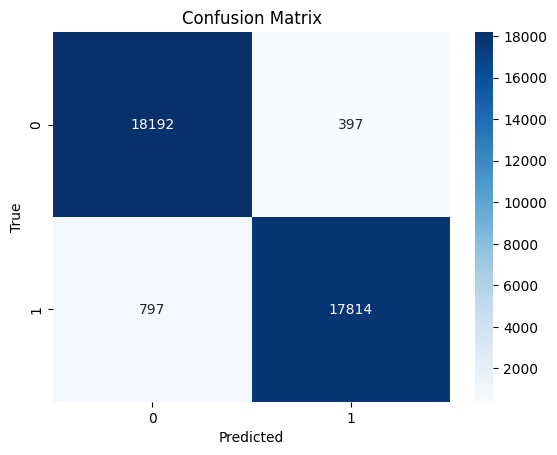

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9580    0.9786    0.9682     18589
      Attack     0.9782    0.9572    0.9676     18611

    accuracy                         0.9679     37200
   macro avg     0.9681    0.9679    0.9679     37200
weighted avg     0.9681    0.9679    0.9679     37200



In [23]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_enhanced_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack'], digits=4))

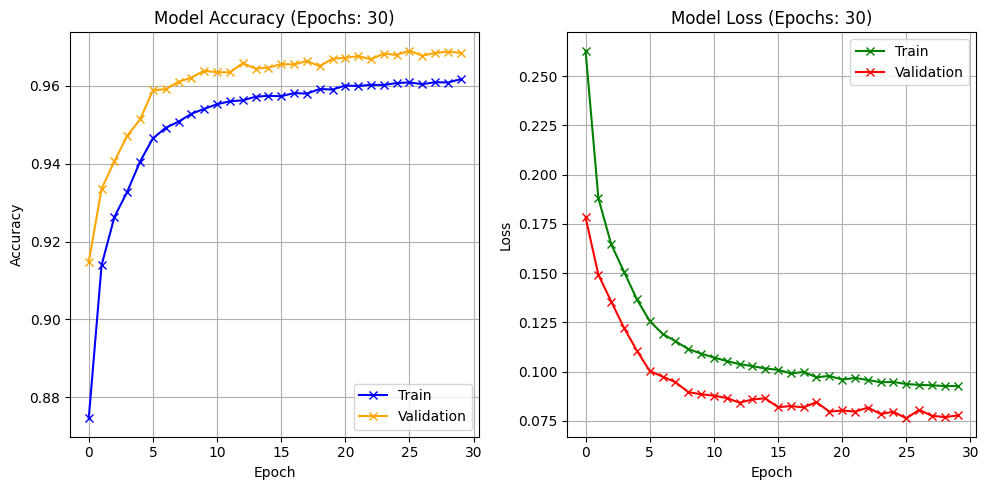

In [25]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='x', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='x', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# **CNN-LSTM Architecture**

In [ ]:
# 2. Membangun Model CNN-LSTM yang Diperbarui
def build_enhanced_model(input_shape, num_classes):
    model = Sequential(name="Enhanced_CNN_LSTM")

    # Blok CNN 1
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu',
                    input_shape=input_shape,
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    # Blok CNN 2
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    # Blok CNN 3
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu',
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Lapisan LSTM yang Diperkuat
    model.add(LSTM(128, return_sequences=True,
                 kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))

    # Fully connected layers dengan regularisasi
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Membangun model dengan input shape yang sesuai
input_shape = (X_train.shape[1], 1)
model = build_enhanced_model(input_shape, num_classes)

# Kompilasi model dengan learning rate yang dioptimalkan
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks yang lebih komprehensif
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=15,
                              mode='max',
                              restore_best_weights=True,
                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1)

checkpoint = ModelCheckpoint('best_enhanced_model.keras',
                           monitor='val_accuracy',
                           save_best_only=True,
                           mode='max')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 3. Melatih Model dengan Validasi
history = model.fit(
    X_train, y_train,
    epochs=30,  # Meningkatkan jumlah epoch
    batch_size=64,  # Menyesuaikan batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.8204 - loss: 0.8118 - precision: 0.8204 - recall: 0.8204 - val_accuracy: 0.9933 - val_loss: 0.2791 - val_precision: 0.9933 - val_recall: 0.9933 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9876 - loss: 0.2479 - precision: 0.9876 - recall: 0.9876 - val_accuracy: 0.9980 - val_loss: 0.1102 - val_precision: 0.9980 - val_recall: 0.9980 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9951 - loss: 0.1033 - precision: 0.9951 - recall: 0.9951 - val_accuracy: 0.9993 - val_loss: 0.0568 - val_precision: 0.9993 - val_recall: 0.9993 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9962 - loss: 0.0625 - precision: 0.9962 - recall: 0.9962 - val_accuracy: 0.9990 - val_loss: 0.0419 - val_precision: 0.9990 - val_recall: 0.9990 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Evaluation Metrics:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999


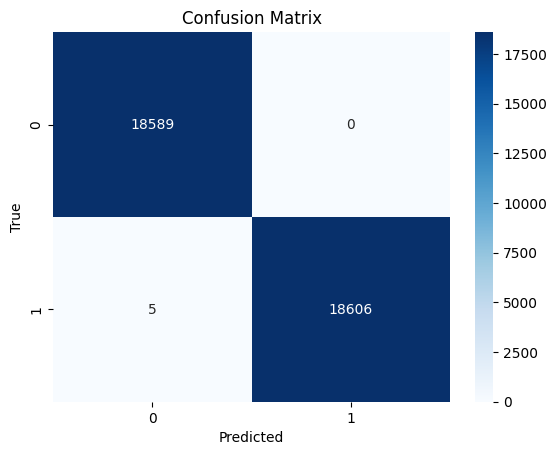

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9997    1.0000    0.9999     18589
      Attack     1.0000    0.9997    0.9999     18611

    accuracy                         0.9999     37200
   macro avg     0.9999    0.9999    0.9999     37200
weighted avg     0.9999    0.9999    0.9999     37200



In [ ]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_enhanced_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack'], digits=4))

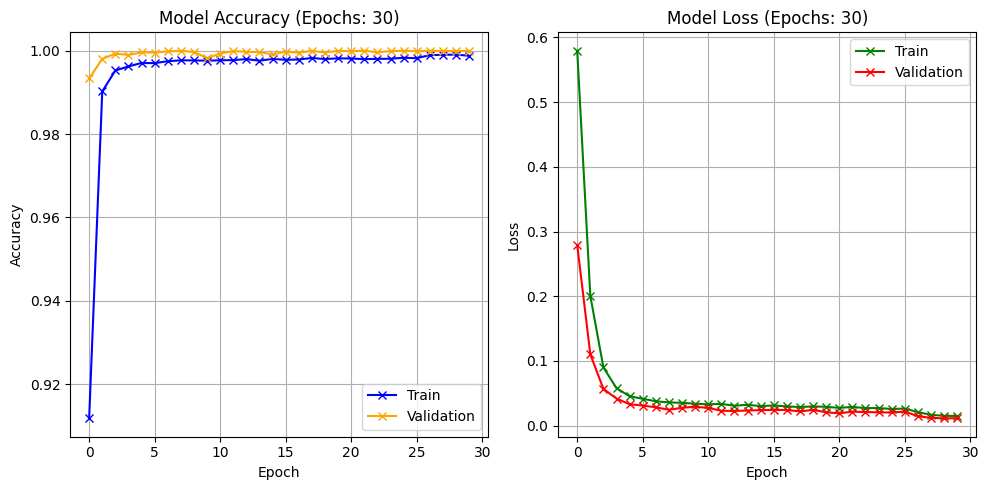

In [ ]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='x', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='x', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# **LSTM Architecture**

In [13]:
# 2. Membangun Model CNN-LSTM yang Diperbarui
def build_enhanced_model(input_shape, num_classes):
    model = Sequential(name="Enhanced_CNN_LSTM")

    # Reshape input for LSTM
    model.add(tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape))

    # Lapisan LSTM yang Diperkuat
    model.add(LSTM(128, return_sequences=True,
                 kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))

    # Fully connected layers dengan regularisasi
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Membangun model dengan input shape yang sesuai
input_shape = (X_train.shape[1],) # Correct input shape for reshape layer
model = build_enhanced_model(input_shape, num_classes)

# Kompilasi model dengan learning rate yang dioptimalkan
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks yang lebih komprehensif
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=15,
                              mode='max',
                              restore_best_weights=True,
                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1)

checkpoint = ModelCheckpoint('best_enhanced_model.keras',
                           monitor='val_accuracy',
                           save_best_only=True,
                           mode='max')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# 3. Melatih Model dengan Validasi
history = model.fit(
    X_train, y_train,
    epochs=30,  # Meningkatkan jumlah epoch
    batch_size=64,  # Menyesuaikan batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.8777 - loss: 0.4593 - precision: 0.8777 - recall: 0.8777 - val_accuracy: 1.0000 - val_loss: 0.0884 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9965 - loss: 0.0823 - precision: 0.9965 - recall: 0.9965 - val_accuracy: 1.0000 - val_loss: 0.0295 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9981 - loss: 0.0293 - precision: 0.9981 - recall: 0.9981 - val_accuracy: 1.0000 - val_loss: 0.0123 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9992 - loss: 0.0135 - precision: 0.9992 - recall: 0.9992 - val_accuracy: 1.0000 - val_loss: 0.0073 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


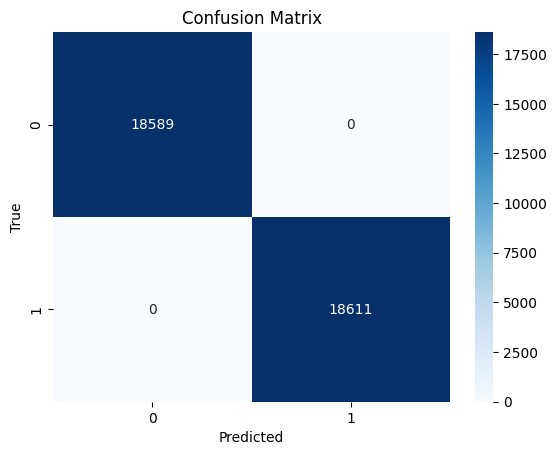

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     18589
      Attack       1.00      1.00      1.00     18611

    accuracy                           1.00     37200
   macro avg       1.00      1.00      1.00     37200
weighted avg       1.00      1.00      1.00     37200



In [16]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_enhanced_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack']))

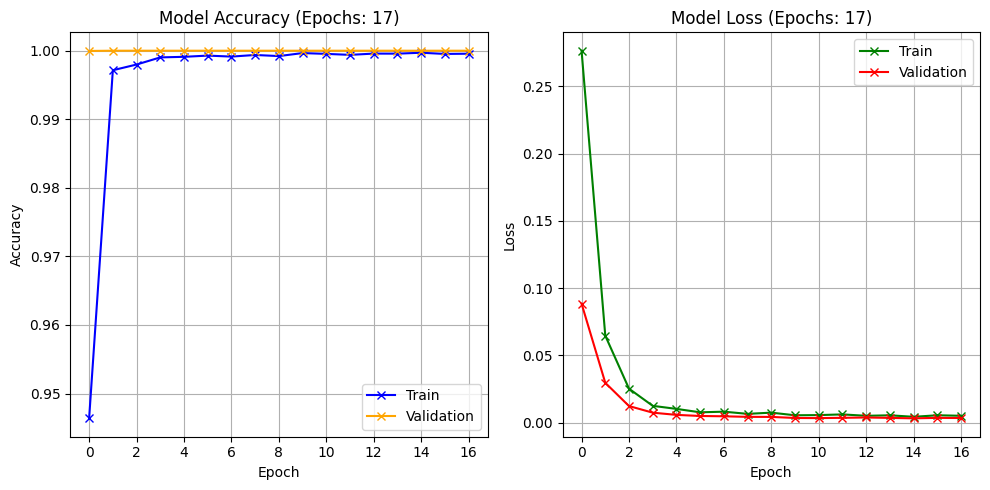

In [18]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='x', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='x', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()